# 6-9. 프로젝트: CAM을 만들고 평가해 보자

### 목차

#### 0. 모델 준비하기
#### 1. CAM 구현하기
#### 2. Grad-CAM 구현하기
#### 3. 바운딩 박스 구하기
#### 4. IoU 구하기
#### 5. 루브릭 & 회고 & Reference

## 0. 모델 준비하기
---

### 0-1. 필요한 라이브러리 import
---

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [2]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 0-2. 데이터셋 불러오기
---
이번 프로젝트에서는 `stanford_dogs` 데이터셋을 사용해서 진행해 보도록 하겠습니다.

`stanford_dogs` 데이터셋

- 120 종의 개를 사진으로 판별하는 분류 문제

- 라벨이 위치 정보인 바운딩 박스(bounding box) 정보 포함

- 총 20,580장의 이미지에서 12,000장은 학습셋이고,

- 나머지 8,580장은 평가용 데이터셋으로 구성되어 있습니다.

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


- `tfds.show_examples()` : 이미지의 클래스와 그 인덱스(index) 확인

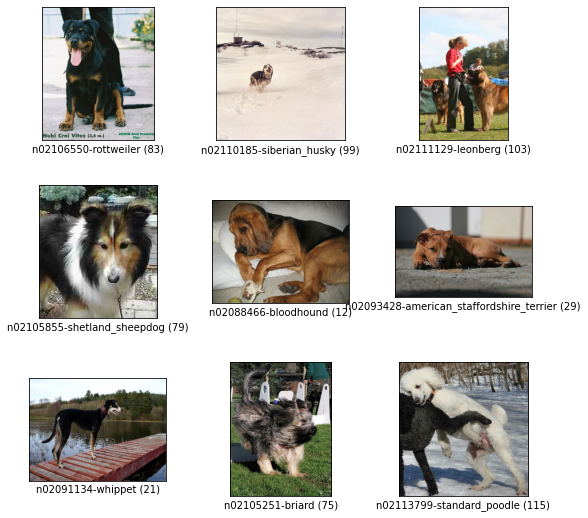

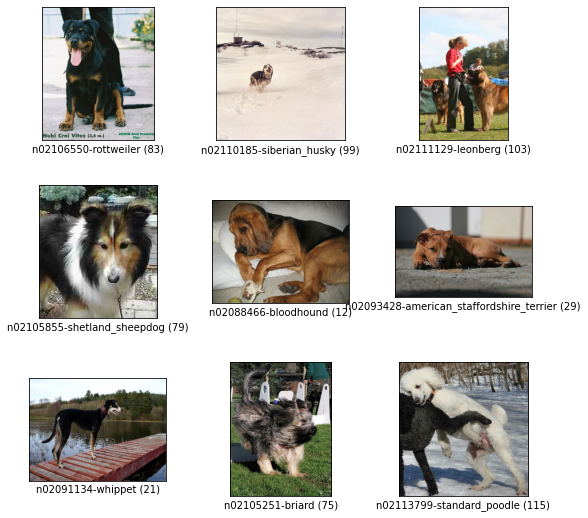

In [4]:
# train dataset 의 이미지의 클래스와 index 확인
tfds.show_examples(ds_train, ds_info)

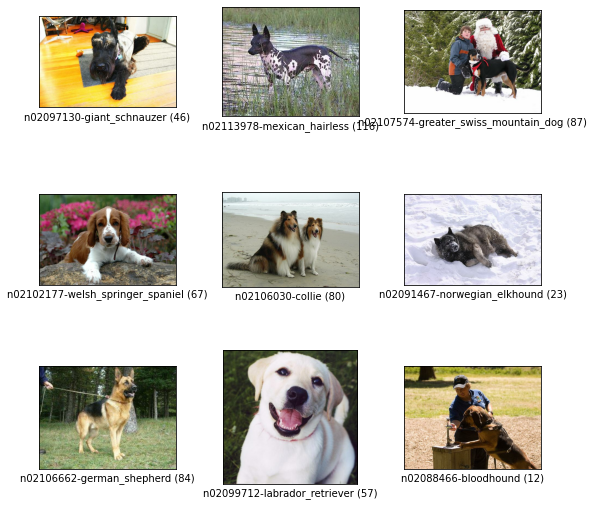

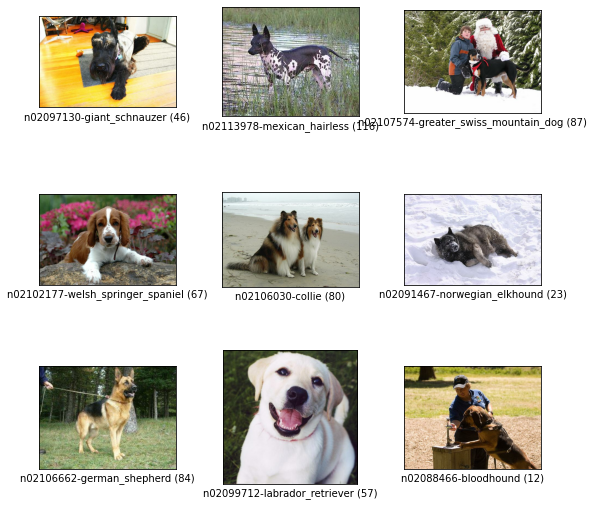

In [5]:
# test dataset 의 이미지의 클래스와 index 확인
tfds.show_examples(ds_test, ds_info)

### 0-3. 물체의 위치 정보 확인
---
원본 이미지 위에 물체의 위치 정보는 어떻게 시각화 하여 표시 할 수 있을까요?

우선 dataset의 메타 정보인 `df_info`를 조회해 `features`가 어떻게 구성되어 있는지 확인해보도록 하겠습니다.

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

먼저 `image`와 `label`은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스이며,

`bbox(바운딩 박스)`는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다.

위에서 확인한 바로는 `BBoxFeature`이라는 타입으로 정의되어 있습니다.

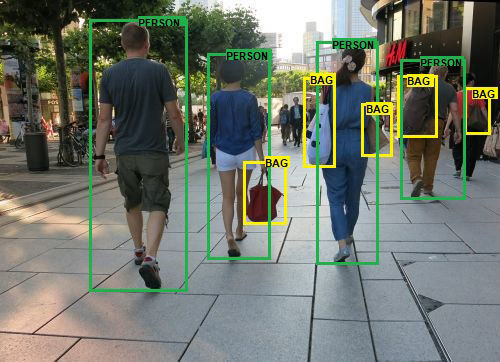

### 바운딩 박스를 표시하는 방법들
---
바운딩 박스를 라벨링하는 방법은 아주 다양합니다.

그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.

- 'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.

    - (예) (x_center, y_center, width, height)
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.


- 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.

    - (예) (x_min, x_max, y_min, y_max)
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.

위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다.

따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.

- [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

-> 해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.

### 0-4. CAM 모델 만들기
---

`CAM(Class Activation Map)` 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer) 가 붙는 형태로 구성되어야 한다는 제약이 있습니다.

cf) 소프트맥스 레이어(softmax layer)는 소프트맥스 함수로 사용하는 fully connected layer 입니다.

CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다.

CAM은 `클래스에 대한 활성화 정도를 나타낸 지도`입니다. 따라서 기본적으로 우리의 모델은 `분류(classfication) 를 수행하는 모델`이어야 합니다.

하지만 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

우선 직접 ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해보도록 하겠습니다.

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다.

다만 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다.

우리의 경우 ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.

[tf.keras.applications.resnet50.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

아래에서 직접 만든 CAM모델을 확인해 주세요

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 0-5. CAM 모델 학습하기
---
 `normalize_and_resize_img()` : 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 수행
 
 `apply_normalize_on_dataset()` : 배치를 구성

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다.

CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


- image의 shape 는 (16, 224, 224, 3) 이며,

    batch_size = 16, 224 x 224 크기를 가진 RGB 3 채널 값을 가진 컬러 이미지 라는 것을 알 수 있으며,

- label의 shape 는 (16,) 로 batch_size = 16 로 생성된 1차원 행렬인 것을 확인 할 수 있습니다.

In [10]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 372s 444ms/step - loss: 3.1984 - accuracy: 0.2852 - val_loss: 3.4919 - val_accuracy: 0.1943
Epoch 2/15
750/750 [==============================] - 317s 423ms/step - loss: 0.9332 - accuracy: 0.7337 - val_loss: 1.2022 - val_accuracy: 0.6546
Epoch 3/15
750/750 [==============================] - 317s 423ms/step - loss: 0.3790 - accuracy: 0.9046 - val_loss: 0.9639 - val_accuracy: 0.7219
Epoch 4/15
750/750 [==============================] - 317s 423ms/step - loss: 0.1092 - accuracy: 0.9828 - val_loss: 0.9172 - val_accuracy: 0.7309
Epoch 5/15
750/750 [==============================] - 317s 423ms/step - loss: 0.0463 - accuracy: 0.9983 - val_loss: 0.8904 - val_accuracy: 0.7450
Epoch 6/15
750/750 [==============================] - 317s 423ms/step - loss: 0.0330 - accuracy: 0.9981 - val_loss: 0.9219 - val_accuracy: 0.7425
Epoch 7/15
750/750 [==============================] - 317s 423ms/step - loss: 0.0229 - accuracy: 0.9991 - val_loss: 0.9445 -

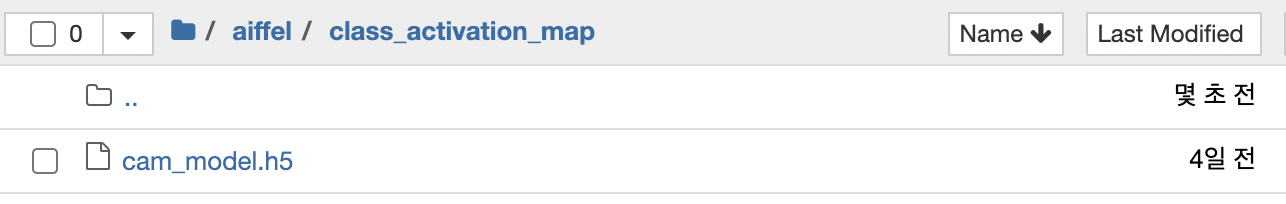

전에 노드를 진행하면서 저장해 놓았던 가중치를 가지고 아래의 프로젝트를 진행해 보도록 하겠습니다.

In [ ]:
# 학습한 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

## 1. CAM 구현하기
---

> 위에서 학습한 모델을 활용하여 CAM을 생성해 볼 것입니다.
>
> 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권합니다.


In [1]:
# 커널 재시작으로 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import os


(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 해줍니다.

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

label: 116


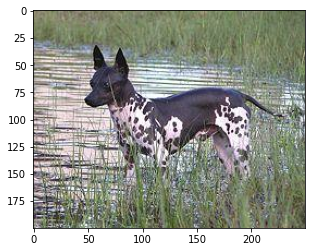

In [3]:
item = get_one(ds_test)
print('label:', item['label'])
print('='*50)
plt.imshow(item['image'])
plt.show()

이제 데이터가 준비 되었습니다.

In [4]:
# CAM을 생성하기 위해 이전에 학습한 모델을 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


CAM을 생성하기 위해서는

> (1) 특성 맵  
> (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치  
> (3) 원하는 클래스의 출력값

이 필요합니다.

또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다.

이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

`generate_cam()` 을 구현하기 위해 아래에서는 `conv_ouputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다.

마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`해 주었습니다.

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다.

생각보다 위치를 정확하게 표현하고 있음을 확인 할 수 있습니다.

2) 만든 함수로 CAM 이미지를 생성합시다.

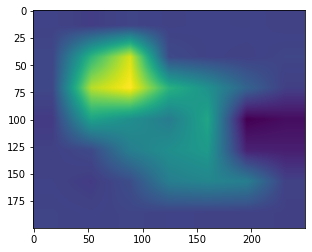

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐 봅시다.

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

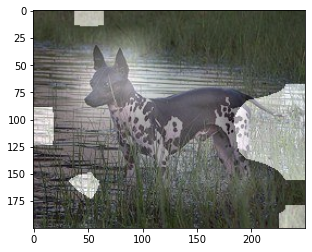

In [9]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

주로 강아지의 얼굴과 몸통이 있는 부분이 강조 되는 경향이 있는데, 이것은 사람이 개를 식별할 떄 유의해서 보는 부분과 일맥상통합니다.

## 2. Grad-CAM 구현하기
---

### 2-1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다.

적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 `cam_model`을 그대로 활용하도록 하겠습니다.

label: 100


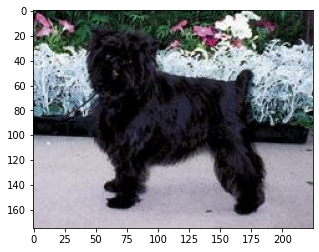

In [10]:
# 새로운 이미지를 뽑아봅시다.
item = get_one(ds_test)
print('label:', item['label'])
print('='*50)
plt.imshow(item['image'])
plt.show()

이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

`grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다.

최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 합니다.

아래 `generate_grad_cam()` 에서는 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`로 활용합니다.

In [11]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 2-2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

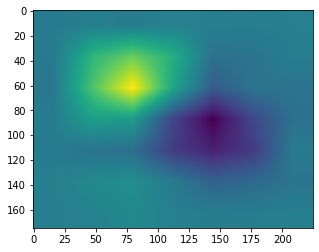

In [12]:
# conv5_block3_out CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

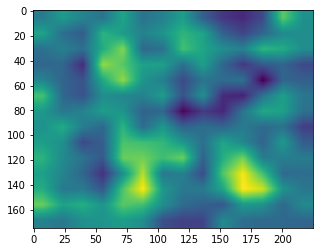

In [14]:
# conv4_block3_out CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

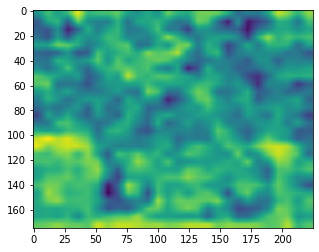

In [16]:
# conv3_block3_out CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 2-3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

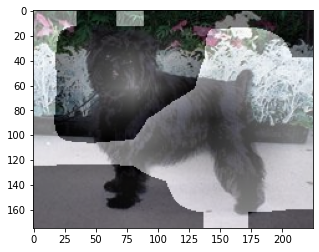

In [13]:
# conv5_block3_out 이미지 시각화
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

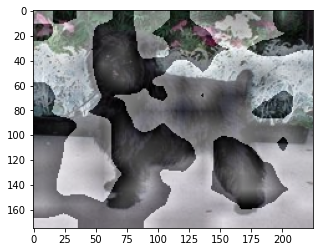

In [15]:
# conv4_block3_out 이미지 시각화
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

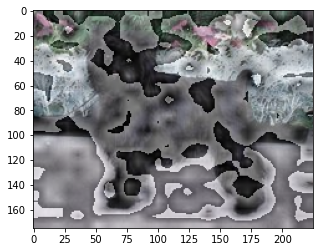

In [17]:
# conv3_block3_out 이미지 시각화
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 3. 바운딩 박스 구하기
---
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

### 3-1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

84


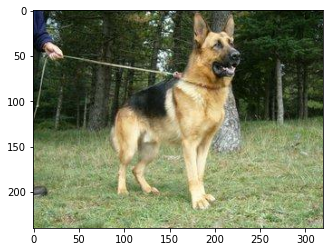

In [18]:
# 새로운 이미지를 다시 뽑아 봅시다.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

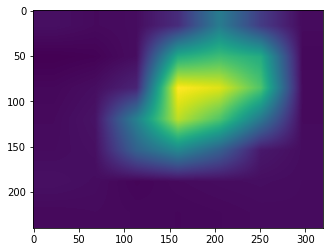

In [19]:
# 새로운 이미지에서의 CAM 이미지를 확인해 봅시다.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던 `generate_cam()`을 활용해서 CAM 이미지를 뽑았습니다.

아래 `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

In [20]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [21]:
rect = get_bbox(cam_image)
rect

array([[ 72,   0],
       [293,   0],
       [293, 183],
       [ 72, 183]])

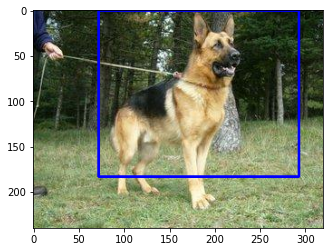

In [22]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

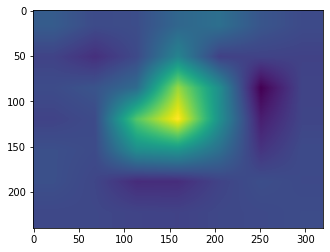

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [24]:
image = copy.deepcopy(item['image'])

grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 72,   0],
       [249,   0],
       [249, 175],
       [ 72, 175]])

### 3-2. 3-1 에서 얻은 바운딩 박스를 시각화해 보세요.

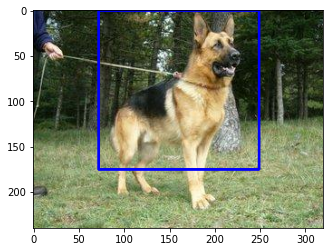

In [25]:
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 4. IoU 구하기


### 4-1. 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [26]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [27]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.225, 0.7625, 0.915625]

In [28]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.0, 0.225, 0.7291666666666666, 0.778125]

In [29]:
# 데이터의 ground truth bbox를 확인
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

In [30]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [31]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6272090421113999

In [32]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.7273671818947324

### 정리

- get_iou() 함수로 IoU를 측정해 본 결과, 바운딩 박스(ground truth)는 0.627 가량의 결과를 내었고, 예측값 바운딩 박스(prediction box)는 0.72 라는 결과값을 돌출하였습니다.

## 5. 루브릭 & 회고 & Reference

### 루브릭
---

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?

- ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?

- CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?

- CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

### 회고
---

- 우선, ResNet을 구현할 때, 생 노가다 혹은 함수화를 진행을 해야 구현을 할 수 있다고 생각했었는데, `tf.keras.applications.resnet50.ResNet50`를 통해서 간단하게 사용 가능하다는 것이 본인에게는 너무 센세이셔녈하게 느껴졌습니다.

- 이후, CAM & Grad-DAM 의 차이를 알아보는 시간을 가졌었는데, 개인적으로 본인이 이를 정리하지 못해서 방학 전으로 이에 대해서 확실하게 정리를 해보려고 합니다.

- 또한, 이 프로젝트를 진행하기 전의 프로젝트가 다 빡셌어서 그런 지 상태적으로 이번 프로젝트의 난이도는 낮다고 느껴졌습니다.

- 물론 이번 프로젝트가 앞에서 배운 내용을 구현하고 적용하는 식이었다보니 상대적으로 난이도가 낮았던 거 같은데, 본인의 역량으로 진행했다기 보다는 노드에 내와 있는 내용을 복사 & 붙여넣기로 진행하다 보니 개인적으로 제대로 공부했다는 느낌을 갖지 못한 것으로 보입니다.
    
- 우선 이번 주말 전으로 그 동안 진행했던 프로젝트에 대한 정리와 앞으로의 미래에 대한 계획을 짜볼 예정이므로, 부족한 역량은 최대한 빠른 시일 내로 채워 놓도록 하겠습니다.

### Reference
---

- [CAM 논문 요약/리뷰](https://jays0606.tistory.com/4)
- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)
- [CNN 개념 정리](http://taewan.kim/post/cnn/)
- [IOU 개념 영상](https://www.youtube.com/watch?v=ANIzQ5G-XPE)